In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import genextreme as gev
from scipy.stats import genpareto as gpd
from scipy.stats import genextreme
from scipy.stats import linregress
from scipy.ndimage import gaussian_filter1d

from pyextremes import get_extremes, get_return_periods
from pyextremes.plotting import plot_extremes

import matplotlib.pyplot as plt
import seaborn as sns

import lmfit
from itertools import groupby
from operator import itemgetter
from lmfit import Model
import statsmodels.api as sm
from tabulate import tabulate
from scipy.optimize import minimize

#added to ignore warnings caused by dividing by zero
import warnings
warnings.filterwarnings('ignore')

# TG10x - 10-day running mean of daily maximum temperature
https://doi.org/10.1029/2021EF002271 

- <em>"We have previously found that using the maximum of the 3-day running mean of daily mean temperature (TG3x) is more appropriate for health impacts in Europe and gives very similar results (as TXx)."</em>
- daily maximum temperature is tested
- observed heatwave was 10-days long, with very high temperatures therefore we choose using the maximum of the 10-day running mean of daily mean temperature (TG10x) 

In [2]:
#### Calculation of event definition #####

ds_temp = xr.open_dataset("indata/tx_srb_19502025.nc") #read input file
t2m = ds_temp['t2m'].mean(dim=["latitude", "longitude"]).sel(valid_time=slice("1950-01-01", "2024-12-31")) - 273.16 #exclude the observed event! change K to C!
ravg=3 #no of days for calculating running average

#calculate the running mean
center = True
t_ravg = t2m.rolling(valid_time=ravg, center=center).mean()

#choose season
season = 'JJ25'
#t_ravg_ses = t_ravg.sel(valid_time=t_ravg['valid_time'].dt.season == season) # !Attention! to how dimension 'time' is named in the file; era5land: 'valid_time'

#'''
#-------------------------------------------------------------------------------------------
#choose single month or particular period during the year:
t_ravg_ses = t_ravg.sel(
    valid_time=((t_ravg['valid_time'].dt.month == 6) & (t_ravg['valid_time'].dt.day >= 1)) |
               ((t_ravg['valid_time'].dt.month == 7) & (t_ravg['valid_time'].dt.day <= 26))
)
#-------------------------------------------------------------------------------------------
#'''  

#calculating the index value for event of interest, as we haven't select it before
t_event = ds_temp['t2m'].mean(dim=["latitude", "longitude"]).sel(valid_time=slice("2025-06-01", "2025-07-26")).rolling(valid_time=ravg, center=True).mean().max() - 273.16
print(t_event)
#maximum of t_ravg -> t_ravg per year (for JJA)
t_ravgX_ses = t_ravg_ses.groupby("valid_time.year").max()
print(t_ravgX_ses)

<xarray.DataArray 't2m' ()> Size: 8B
array(34.99734863)
<xarray.DataArray 't2m' (year: 75)> Size: 300B
array([35.075764, 30.898264, 32.566853, 30.777395, 28.306803, 28.863586,
       27.018759, 32.74663 , 32.281536, 27.420176, 29.810455, 29.077738,
       29.937967, 31.012054, 28.427338, 32.29011 , 28.565298, 29.65272 ,
       31.936005, 26.451223, 28.96282 , 29.144949, 29.19101 , 31.941702,
       31.115194, 28.774271, 28.044992, 27.919708, 27.255209, 27.999176,
       28.12673 , 29.30303 , 32.226257, 28.88384 , 32.420197, 28.551443,
       26.28949 , 34.298756, 34.96828 , 29.587046, 30.507019, 29.33779 ,
       28.198385, 32.303192, 30.474905, 28.79072 , 31.362183, 31.80368 ,
       31.580149, 29.382141, 35.011486, 31.103598, 31.593618, 30.60023 ,
       32.093494, 28.990896, 31.001343, 36.18443 , 32.346516, 32.34785 ,
       31.266745, 32.402008, 32.856213, 31.60377 , 28.060404, 33.025715,
       31.304047, 32.632843, 27.92331 , 31.06954 , 28.97053 , 33.900604,
       33.436993, 32.

In [3]:
#### Linear regression function
#fit line y = a * x + b ; a-slope, b-intercept
def linreg(x,y):
    a, b = np.polyfit(x, y, 1)
    y_pred = a * x + b
    return a, b, y_pred

In [4]:

years = t_ravgX_ses['year'].squeeze().values # extract years from input file
temps = t_ravgX_ses.squeeze().values

a, b, tX_pred = linreg(years,temps)

#### Plot event index and its temporal trend

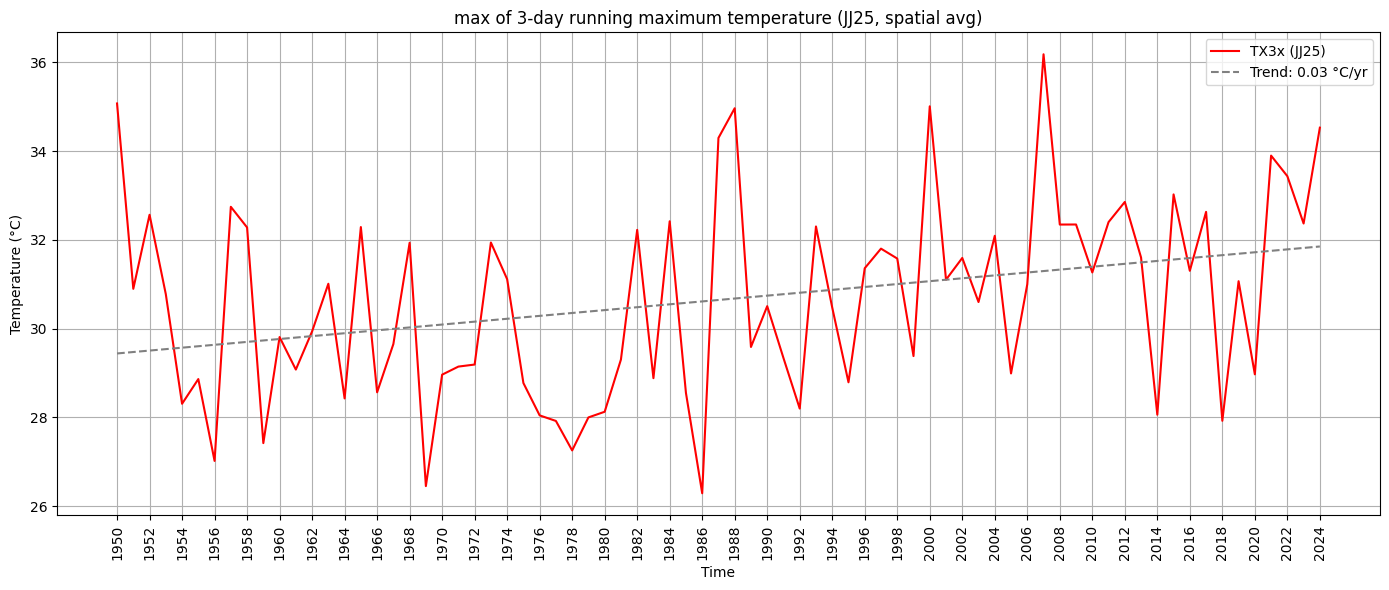

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(years, temps, label=f"TX{ravg}x ({season})", color='r') # change label for different event definition
plt.plot(years, tX_pred, color='grey', linestyle='--', label=f'Trend: {a:.2f} °C/yr') # change legend, units.. 
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.xticks(ticks=years[::2], rotation=90)
plt.title(f"max of {ravg}-day running maximum temperature ({season}, spatial avg)") # change title 
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"figs/t_ravg{ravg}_{season}_1950-2025.png")
plt.show()

## Global mean surface temperature (gmst)

https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/download.html met office 

- GMST anomaly - yearly mean

In [6]:
ds_gmst = xr.open_dataset("indata/tas_mean_mon_1950-2024.nc") #monthly mean GMST anomaly 1880-2024
#print(ds_gmst)
gmst = ds_gmst['tas_mean'].groupby('time.year').mean('time').sel(year=slice("1950", "2024")) # Calculate yearly mean from monthly values; 1950-2024 or 1950-2023 if we want to exclude the observed event!
#plt.plot(gmst)

To calculate a trend in transient data, some parameters in these statistical models are made a function of an indicator of global warming (or another covariate; the same methods can be used to investigate the dependence on e.g. El NiñoSouthern Oscillation, ENSO). For global warming a common choice is the 4-year smoothed global mean surface temperature (GMST) anomaly.

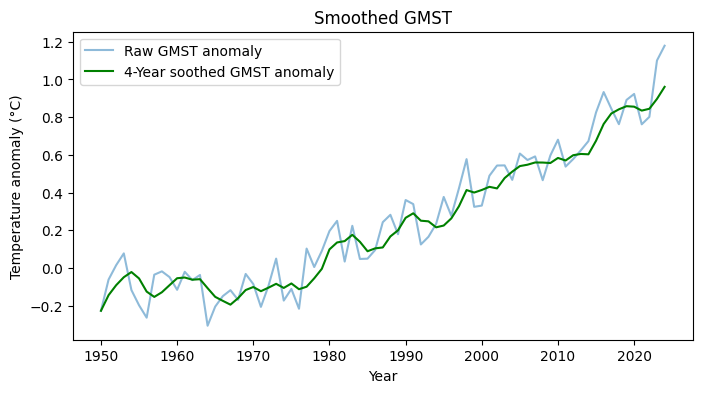

In [7]:
#### Smooth GMST anomaly and plot raw vs. smoothed data

y=gmst['year'].to_numpy()
gmst_4yr = gmst.rolling(year=4, min_periods=1).mean()  #4-year rolling avg

plt.figure(figsize=(8, 4))
plt.plot(y, gmst.to_numpy(), label="Raw GMST anomaly", alpha=0.5)
plt.plot(y, gmst_4yr.to_numpy(), label="4-Year soothed GMST anomaly", color="green")
plt.xlabel("Year")
plt.ylabel("Temperature anomaly (°C)")
plt.legend()
plt.title("Smoothed GMST")
plt.show()

## Probability function fit

In [8]:
def plot_distribution_fit(data, idx_name, bins=0.3, dist_list=None):
    """
    Fits multiple distributions to the given data, plots the histogram and the PDFs, 
    and returns the fitted parameters.

    Parameters:
    - data: array-like, the dataset to analyze.
    - idx_name: string, name of the analyzed index.
    - bins: float, bin width for the histogram.
    - dist_list: list of tuples (distribution, color, label), 
                 where `distribution` is a scipy.stats distribution.

    Returns:
    - fitted_params: dict, parameters of the fitted distributions.
    """

    if dist_list is None:
        dist_list = [
            (stats.norm, 'magenta', 'Normal'),
            (stats.gamma, 'green', 'Gamma'),
            (stats.lognorm, 'blue', 'Lognormal'),
            (stats.genextreme, 'orange', 'GEV')
        ]
    
    x_range = np.linspace(data.min(), data.max(), 100)
    bins = np.arange(data.min(), data.max(), bins)

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(data, bins=bins, stat="density", alpha=0.5, ax=ax, color='gray', label='Data')

    fitted_params = {}

    #fit
    for dist, color, label in dist_list:
        params = dist.fit(data)
        fitted_params[label] = params
        pdf_values = dist.pdf(x_range, *params)
        ax.plot(x_range, pdf_values, lw=2, color=color, label=label)
    for fit in fitted_params:    
        print(f"{fit}:{fitted_params[fit]}")

    ax.legend()
    ax.set_xlabel(f"{idx_name}")
    ax.set_ylabel("Density")
    ax.set_title("Fitted Distributions")
    plt.savefig("figs/hist_TX"+idx_name+".png", dpi = 300)
    
    return fitted_params

Normal:(30.646498, 2.2214167)
Gamma:(70.50172056682979, 12.004018701562789, 0.2643478473363955)
Lognormal:(0.13090001, 13.655877590180356, 16.846014)
GEV:(0.2100870368004532, 29.789614235555824, 2.0981058116706954)


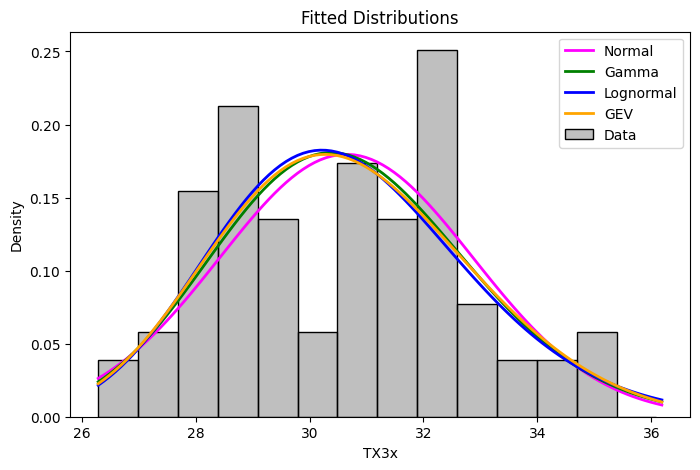

In [9]:
fitted_parameters = plot_distribution_fit(temps, f'TX{ravg}x', bins=0.7) # change index name for plot

In [10]:
def plot_cdf(data, idx_name, dist_list=None):
    """
    Fits multiple distributions to the given data, plots the empirical CDF and the fitted CDFs,
    and returns the fitted parameters.

    Parameters:
    - data: array-like, the dataset to analyze.
    - idx_name: string, name of the analyzed index.
    - dist_list: list of tuples (distribution, color, label), 
                 where `distribution` is a scipy.stats distribution.

    Returns:
    - fitted_params: dict, parameters of the fitted distributions.
    """

    if dist_list is None:
        dist_list = [
            (stats.norm, 'magenta', 'Normal'),
            (stats.gamma, 'green', 'Gamma'),
            (stats.lognorm, 'blue', 'Lognormal'),
            (stats.genextreme, 'orange', 'GEV')
        ]

    x_range = np.linspace(data.min(), data.max(), 100)

    fig, ax = plt.subplots(figsize=(12, 7.5))

    sorted_data = np.sort(data)
    empirical_cdf = np.arange(1, len(sorted_data) + 1) / (len(sorted_data) + 1)
    ax.plot(sorted_data, empirical_cdf, marker="o", linestyle="none", label="Empirical CDF", color="black")

    fitted_params = {}

    #fit
    for dist, color, label in dist_list:
        params = dist.fit(data)
        fitted_params[label] = params
        cdf_values = dist.cdf(x_range, *params)
        ax.plot(x_range, cdf_values, lw=2, color=color, label=label)
    for x in fitted_parameters:
        print(f"{x}:{fitted_parameters[x]}",end = "\n")
    ax.legend()
    ax.set_xlabel(f'TX{ravg}x')
    ax.set_ylabel("Cumulative Probability")
    ax.set_title("Empirical and Fitted CDFs")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.savefig("figs/cdfs_TX"+idx_name+".png", dpi = 300)
    
    return fitted_params


Normal:(30.646498, 2.2214167)
Gamma:(70.50172056682979, 12.004018701562789, 0.2643478473363955)
Lognormal:(0.13090001, 13.655877590180356, 16.846014)
GEV:(0.2100870368004532, 29.789614235555824, 2.0981058116706954)


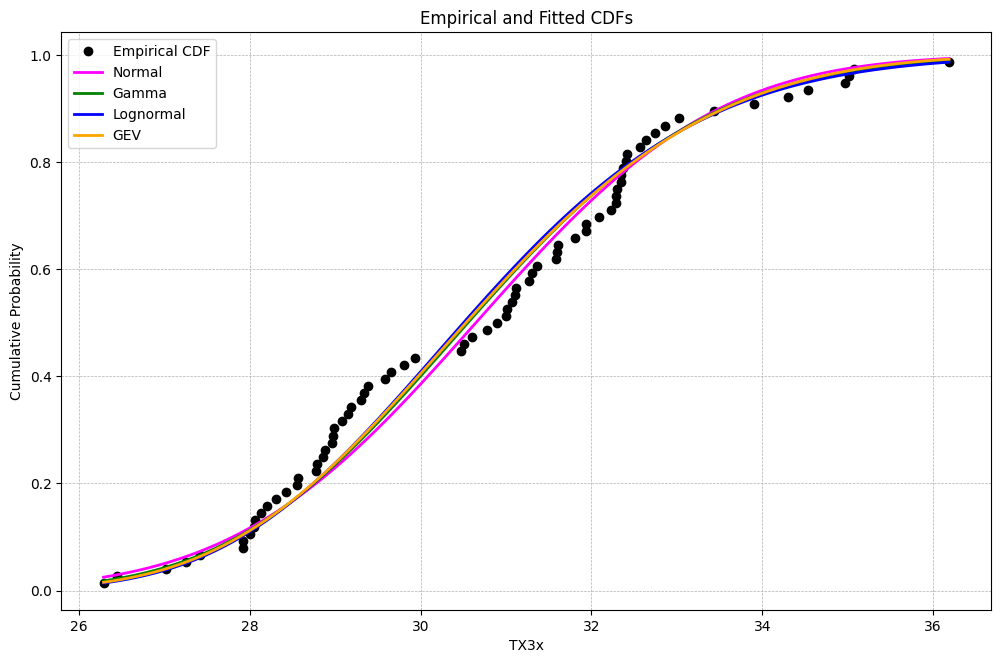

In [11]:
fitted_parameters_cdf = plot_cdf(temps, f'TX{ravg}x')

In [12]:
def plot_quants(data, dist_list=None):

    if dist_list is None:
        dist_list = [
            (stats.norm, 'magenta', 'Normal'),
            (stats.gamma, 'green', 'Gamma'),
            (stats.lognorm, 'blue', 'Lognormal'),
            (stats.genextreme, 'orange', 'GEV')
        ]
        
    x_range = np.linspace(data.min(), data.max(), 100)
    x1 = np.linspace(0,1,100)
    x100 = np.linspace(0,100,100)
    fig, ax = plt.subplots(figsize = (6,6))

    fitted_params = {}

    for dist, color, label in dist_list:
        params = dist.fit(data)
        fitted_params[label] = params
        pdf_values = dist.pdf(x_range, *params)
        ppf_values = dist.ppf(x1, *params)
        ax.scatter(ppf_values,
                   np.quantile(data, x1),
                   lw=2, color=color, label=label)

# actual quantiles of our data
    ax.plot(x100, x100, "k")

# aesthetics
    ax.set_xlim(data.min(), data.max())
    ax.set_ylim(data.min(), data.max())

    ax.set_xlabel("Theoretical distribution quantiles", fontsize = 12)
    ax.set_ylabel("Sample Quantiles", fontsize = 12)
    ax.set_aspect("equal")
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    ax.grid(True)
    ax.set_aspect("equal")
    ax.legend()
    plt.savefig("figs/q-q_TX"+str(ravg)+".png", dpi = 300)


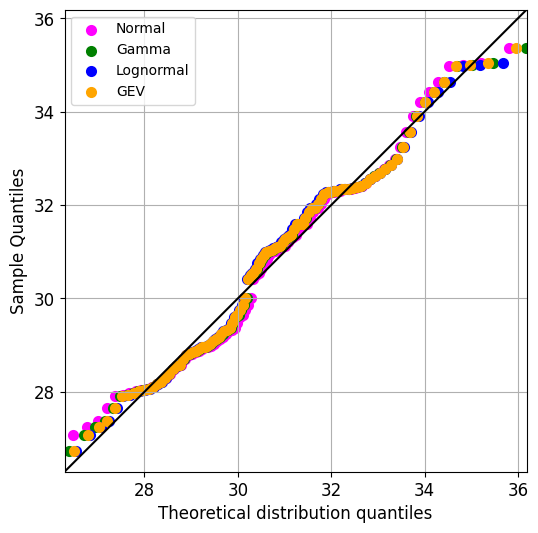

In [13]:
plot_quants(temps)

In [14]:
def return_periods(extreme_data, idx_name, dist_names=None, n_bootstrap=1000, ci=95, event=None):
    """
    Function for calculating and plotting empirical and theoretical return levels with bootstrapped confidence intervals

    Parameters:
    - extreme_data : array-like, data  to analyze
    - idx_name : name of the index used to 
    - dist_names : names of theoretical distributions to consider (as named in scipy.stats), default is None
    - n_bootstrap : the number of data recombination in the bootstrap method, default is 1000
    - ci : the confidence interval determined by bootstrapping, default is 95%
    - event : the value of the observed extreme event, default is None

    """
    sorted_data = np.sort(extreme_data)
    n = len(sorted_data)

    empirical_cdf = np.arange(1, n + 1) / (n + 1)
    empirical_return_periods = 1 /(1 - empirical_cdf)

    plt.figure(figsize=(8, 5))
    plt.plot(empirical_return_periods, sorted_data, marker="o", linestyle="none", label="Empirical", color="black")
    
    x_range = np.linspace(min(extreme_data), max(extreme_data), 100)
    color_map = plt.get_cmap("tab10")
    for i, dist_name in enumerate(dist_names):
        dist = getattr(stats, dist_name)
        params = dist.fit(extreme_data)
        cdf_vals = dist.cdf(x_range, *params)
        return_periods = 1 / (1 - cdf_vals)

        color = color_map(i % 10)  # Cycle through colormap

        plt.plot(return_periods, x_range, label=dist_name, color=color)

        # Bootstrap for confidence intervals
        bootstrapped_levels = []
        for _ in range(n_bootstrap):
            resampled_data = np.random.choice(extreme_data, size=len(extreme_data), replace=True)
            boot_params = dist.fit(resampled_data)
            boot_cdf_vals = dist.cdf(x_range, *boot_params)
            boot_return_periods = 1 / (1 - boot_cdf_vals)
            if not np.inf in boot_return_periods:
                bootstrapped_levels.append(boot_return_periods)

        bootstrapped_levels = np.array(bootstrapped_levels)
        lower_bound = np.percentile(bootstrapped_levels, (100 - ci) / 2, axis=0)
        upper_bound = np.percentile(bootstrapped_levels, 100 - (100 - ci) / 2, axis=0)
        plt.fill_betweenx(x_range, lower_bound, upper_bound, color=color, alpha=0.2,
                          label=f'{dist_name} {ci}% CI')

    if (event != None):
        plt.axhline(y = event,  color="magenta", label="Observed event", linestyle = '--')
        
    plt.xscale("log")  #log scale for return periods
    plt.xlim(1, 10**2) #return periods depicted for this number of years 
    plt.xlabel("Return period (years)")
    plt.ylabel(idx_name+' return periods' )
    plt.title("Return periods with Confidence Intervals for " + idx_name)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(loc="lower right")
    plt.tight_layout()

    plt.savefig("figs/return_periods_emp_"+idx_name+".png", dpi = 300)

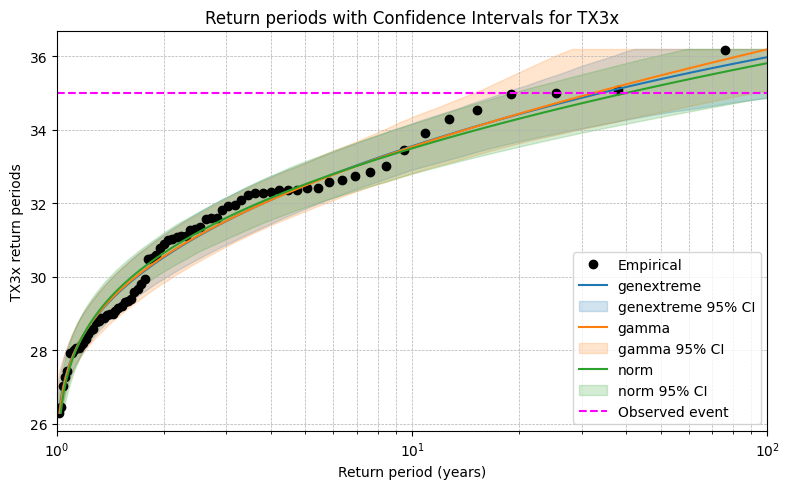

In [15]:
return_periods(temps, f'TX{ravg}x', dist_names=['genextreme', 'gamma', 'norm'], n_bootstrap=1000, ci=95, event = t_event)

## Calculating trend
- To calculate a trend in transient data, some parameters in these statistical models are made a function of an indicator of global warming (or another covariate; the same methods can be used to investigate the dependence on e.g. El NiñoSouthern Oscillation, ENSO). For global warming a common choice is the 4-year smoothed global mean surface temperature (GMST) anomaly

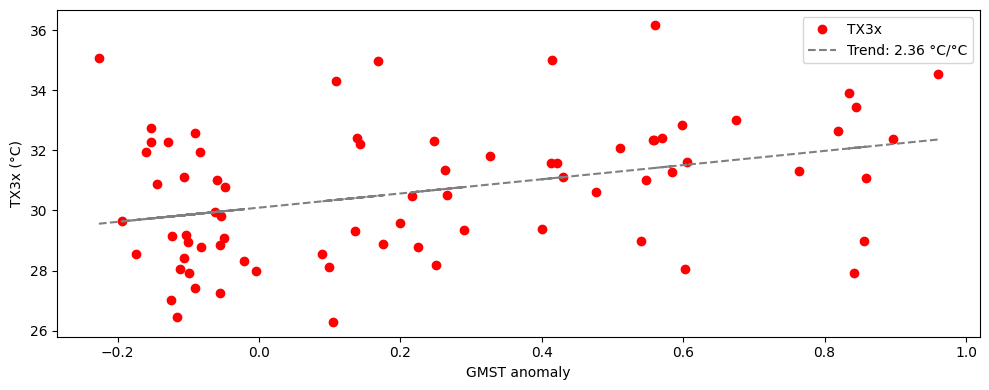

In [16]:
a, b, temps_pred = linreg(gmst_4yr, temps) #regress event definition index on smoothed  gmst anomaly

plt.figure(figsize=(10, 4))
plt.plot(gmst_4yr, temps, label=f'TX{ravg}x',  marker='o', linewidth=0, color='r')
plt.plot(gmst_4yr, temps_pred, color='grey', linestyle='--', label=f'Trend: {a:.2f} °C/°C')
plt.xlabel("GMST anomaly")
plt.ylabel(f"TX{ravg}x (°C)")
#plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/gmst_TX"+str(ravg)+"_regression.png", dpi = 300)

### Shift mean

### Use of maximum likelihood estimation

In the case of a temperature event, it is commonly assumed that the trend shifts with GMST. For observational studies this assumption implies fitting the temperature data to a distribution that shifts proportionally to the smoothed global mean temperature: **μ = μ0 + αGMST** and σ = σ0, with α the trend that is fitted together with μ0 and σ0. The shape parameter ξ is assumed constant.

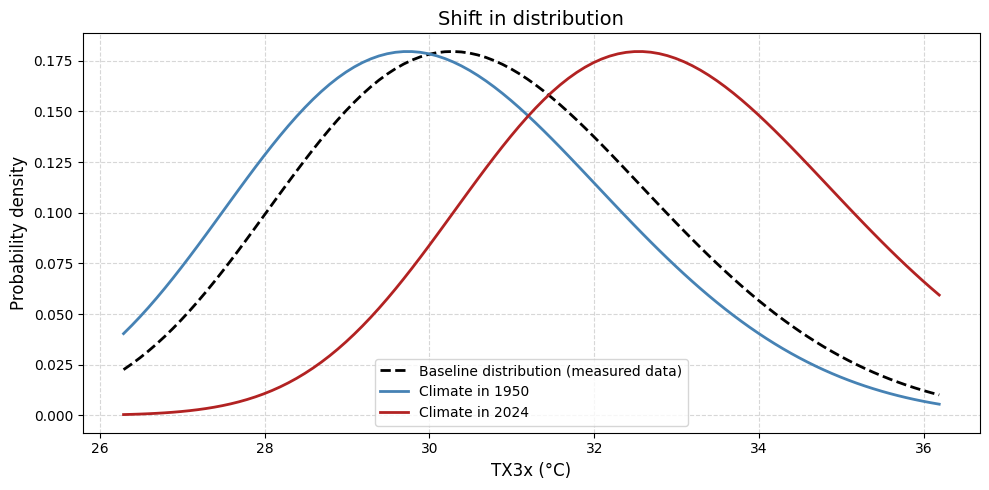

In [17]:
gmst = ds_gmst['tas_mean'].groupby('time.year').mean('time').sel(year=slice("1950", "2024"))
gmst_4yr = gmst.rolling(year=4, min_periods=1).mean()  #4-year rolling avg

#Fitting the data to the distribution that represents it the best
params = stats.genextreme.fit(temps)
c, mu0, sigma = params

#Taking the trend coeffitient between μ and GMST' and adding it to μ0 values 
alpha = a
mu = mu0 + alpha * gmst_4yr
x_range = np.linspace(min(temps), max(temps), 100)


plt.figure(figsize=(10, 5))

#Plotting the distribution obtained from the data
plt.plot(x_range, stats.genextreme.pdf(x_range, *params),
         label='Baseline distribution (measured data)', color='black', linestyle='--', linewidth=2)

#Plotting the distributions obtained from shift fitting 
plt.plot(x_range, stats.genextreme.pdf(x_range, loc=mu[0], scale=sigma , c=c), #first mu value, corresponding to the first year of the data
         label='Climate in 1950', color='steelblue', linewidth=2)

plt.plot(x_range, stats.genextreme.pdf(x_range, loc=mu[-1], scale=sigma, c = c), # last mu value, corresponding to the last year of the data
         label='Climate in 2024', color='firebrick', linewidth=2)

plt.xlabel(f"TX{ravg}x (°C)", fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.title('Shift in distribution', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(frameon=True)
plt.tight_layout()
plt.savefig("figs/dist_shift_TX"+str(ravg)+".png", dpi = 300)


### Calculation of “probability ratio” 

PR = p1/p0, with p1 the probability of an event as strong as or stronger than the extreme event in the current climate and p0 the probability in a counterfactual climate without anthropogenic emissions

In [18]:
def plot_return_levels(event, extreme_data, mu, mu0, dist_name='genextreme', ci=95, label_suffix=''):
    """
    Plotting shifted observational data for the mu value of choice and finding the return level of the observed event of choice.
    Returns the cumulative distribution function value of the observed event in the provided distribution with values for the selected confidence interval.

    Parameters:
    - event: observed value of the studied extreme event
    - extreme_data: observed extreme event values
    - mu0: the observed mean of the distribution
    - mu: the shifted value of mu
    - dist_name: distribution name (default 'genextreme')
    - ci: confidence interval percentage (default 95)
    - label_suffix: string added to plot label (e.g. '1950')

    """
    
    #shifting the observational data to the desired year
    extreme_data = extreme_data + mu - mu0

    x_range = np.linspace(min(extreme_data), max(extreme_data), 100)
    #Return periods for all observed data
    sorted_data = (np.sort(extreme_data))
    n = len(sorted_data)
    emp_cdf_vals = np.arange(1, n + 1) / (n + 1)
    emp_return_periods = 1 / (1 - emp_cdf_vals)

    plt.plot(emp_return_periods, sorted_data, marker="o", linestyle="none", color="black")
  
 
    # re-fitting of the shifted data to the selected distribution
    dist = getattr(stats, dist_name)
    params = dist.fit(extreme_data)
    cdf_vals = dist.cdf(x_range, *params)
    return_periods = 1 / (1 - cdf_vals)
    plt.plot(return_periods, x_range, label=f'{label_suffix} distribution {dist_name}')

    #finding the cdf of the event in the shifted distribution
    cdf_event = dist.cdf(event, *params)
    
    #Bootstrap confidence intervals
    bootstrapped_levels = []
    boot_cdf = []
        
    for _ in range(1000):
        resampled_data = np.random.choice(extreme_data, size = len(extreme_data), replace=True)
        boot_params = dist.fit(resampled_data)
        boot_cdf_vals = dist.cdf(x_range, *boot_params)
        boot_return_periods = 1 / (1 - boot_cdf_vals)
        if not np.inf in boot_return_periods:
            bootstrapped_levels.append(boot_return_periods)
        boot_cdf.append(boot_cdf_vals)

    # Selecting the bootstrapped values (cdf & return periods) corrseponding to the selected confidence levels
    bootstrapped_levels = np.array(bootstrapped_levels)
    lower_boot_cdf =  np.percentile(boot_cdf, (100 - ci) / 2, axis=0)
    upper_boot_cdf = np.percentile(boot_cdf, 100 - (100 - ci) / 2, axis=0)
    
    lower_bound = np.percentile(bootstrapped_levels, (100 - ci) / 2, axis=0)
    upper_bound = np.percentile(bootstrapped_levels, 100 - (100 - ci) / 2, axis=0)

    # Finding the closest values of the confidence intervals on the graph corresponding to the event 
    index = np.where(cdf_vals <= cdf_event)[0]
    lower = lower_boot_cdf[index[-1]]
    upper = upper_boot_cdf[index[-1]]

    index = np.where(cdf_vals >= cdf_event)[0]
    lower1 = lower_boot_cdf[index[0]]
    upper1 = upper_boot_cdf[index[0]]
    
    plt.fill_betweenx(x_range, lower_bound, upper_bound, color='gray', alpha=0.2) 
                     # ,label=f'{label_suffix} {dist_name} {ci}% CI')
    label = ''
    if (mu == mu0): label = 'Observed extreme event'
    plt.axhline(y = event, color = 'magenta', linestyle = '--', linewidth = 1, label = label)

    plt.xscale("log")
    plt.xlim(1, 10**2)
    plt.xlabel("Return period (years)")
    plt.ylim(25, 38)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    return cdf_event, (lower+lower1)/2, (upper+upper1)/2

The probability ratio of the event occuring in 2024 and 1950 climate: 10.27
The 2.5% confidence level of the probability ratio:  6.87
The 2.5% confidence level of the probability ratio:  259.84
The return period of the event in the 2024 climate is 5.767239198851382
The return period of the event in the 1950 climate is 59.24989387515701


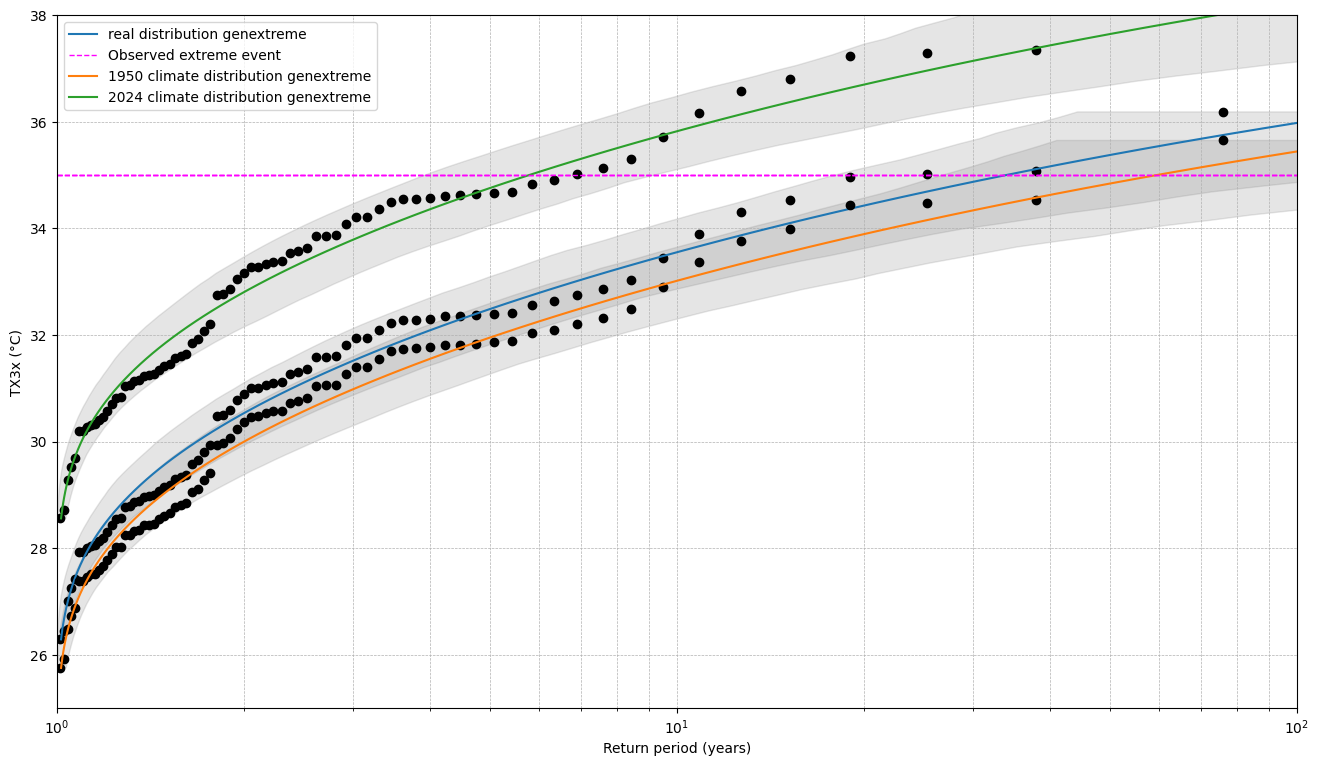

<Figure size 640x480 with 0 Axes>

In [19]:
plt.figure(figsize=(16, 9))

#plot for mu0 (baseline)
plot_return_levels(t_event, temps, mu0 , mu0, label_suffix='real')

#plot for mu[0] (1st year in the dataset)
past, past_low, past_up = plot_return_levels(t_event, temps, mu[0].to_numpy() , mu0, label_suffix='1950 climate')

#plot for mu[-1] (last year, year of the extreme event we are investigating)
now, now_low, now_up = plot_return_levels(t_event, temps, mu[-1].to_numpy() , mu0, label_suffix='2024 climate')

print(f'The probability ratio of the event occuring in 2024 and 1950 climate: {(1-now)/(1-past):5.2f}')
print(f'The 2.5% confidence level of the probability ratio: {(1-now_low)/(1-past_low):5.2f}')
print(f'The 2.5% confidence level of the probability ratio: {(1-now_up)/(1-past_up):7.2f}')
print(f'The return period of the event in the 2024 climate is {1/(1-now)}')
print(f'The return period of the event in the 1950 climate is {1/(1-past)}')

plt.ylabel(f"TX{ravg}x (°C)")
plt.show()
plt.savefig("figs/obs_period_shifted_"+str(ravg)+"_GEV.png", dpi = 300)


In [20]:
RP = 100  # return period of 20 years
prob = 1 - 1/RP

gev_1950 = stats.genextreme(c, loc=mu[0], scale=sigma)
gev_2025 = stats.genextreme(c, loc=mu[-1], scale=sigma) 

I_now = gev_2025.ppf(prob)
I_past = gev_1950.ppf(prob)

delta_I = (I_now - I_past)/t_event
print(f"Change in intensity (1I) for RP={RP} is deltaI = {delta_I.values:5.3f}")

Change in intensity (1I) for RP=100 is deltaI = 0.080
